# Convolutional Neural Networks 

In this notebook, we will further explore convolutional neural networks to see the difference to previous networks. Ee will examine a harder task:

The complete [CIFAR10](https://keras.io/datasets/) Dataset, consists of various pictures of different objects like animals or cars. First, we load numpy and matplotlib as well as the keras layers we need.

In [1]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# keras
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import metrics

** Load CIFAR10 dataset **

We load the CIFAR10 dataset provided by keras, it contains 32x32-pixel images from ten classes.


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


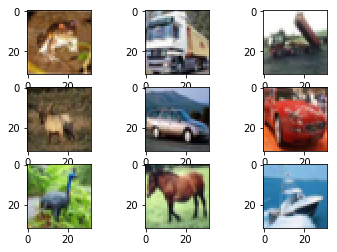

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(x_train[i])
# show the figure
plt.show()



x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

num_classes = 10
batch_size = 128

In the next cell, we set reshape the dataset to have the color channels in the place the backend require. Tensorflow requires "channels_last".

We also convert the labels to one-hot-encoded labels.

In [3]:
# Convert class vectors to binary class matrices.
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

img_rows, img_cols, channels = x_train.shape[1:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(K.image_data_format())
print(input_shape)
print(y_train[0])

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
channels_last
(32, 32, 3)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Baseline: Multi-Layer Perceptron (MLP)

To get a baseline, we try a multi-layer perceptron: A model with a few hidden dense layers. If there are enough of those (>~3), the model can be considered deep.

In [4]:
def makeMLP(hidden = [512,512,256], activation = 'relu', input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    # converts the images (32x32x3) into vectors
    model.add(Flatten(input_shape=input_shape))
    model.add(BatchNormalization())
    for a in hidden:
        model.add(Dense(a, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [5]:
model = makeMLP()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 1,982,218
Trainable params: 1,976,074
Non-trainable params: 6,144
__________________________________________

Note, that this small MLP with three hidden layers of sizes 512, 512 and 256, already has about 2 million trainable parameters. The size of 512 activations is also not unreasonably large, as this already leads to a dimensional reduction of the input by a factor of 6.

In [6]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=20,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 2s 42us/sample - loss: 2.3400 - accuracy: 0.1647 - val_loss: 2.2015 - val_accuracy: 0.2051
Epoch 2/20
50000/50000 [==============================] - 1s 27us/sample - loss: 2.1388 - accuracy: 0.2298 - val_loss: 2.0801 - val_accuracy: 0.2498
Epoch 3/20
50000/50000 [==============================] - 1s 27us/sample - loss: 2.0441 - accuracy: 0.2677 - val_loss: 2.0069 - val_accuracy: 0.2808
Epoch 4/20
50000/50000 [==============================] - 1s 27us/sample - loss: 1.9823 - accuracy: 0.2908 - val_loss: 1.9566 - val_accuracy: 0.3031
Epoch 5/20
50000/50000 [==============================] - 1s 27us/sample - loss: 1.9379 - accuracy: 0.3115 - val_loss: 1.9179 - val_accuracy: 0.3198
Epoch 6/20
50000/50000 [==============================] - 1s 27us/sample - loss: 1.9008 - accuracy: 0.3257 - val_loss: 1.8859 - val_accuracy: 0.3322
Epoch 7/20
50000/50000 [==============================] 

We can note down, that the validation accuray maxes out at about 53%. This is not nothing, as with ten classed, pure guessing would give an accuracy of 10%.

It also starts overfitting quite quickly. This could be mitigated by using data augmentation and more regularization to an extent, which could also inprove the generalization somewhat. But we want to focus on the comparison with convnets here and thus will keep the other aspects simple. 

# Convolutional Neural Network

Let us no go to a very simple CNN. We compared to the previous MLP, we only replace the two larger hidden layers near the bottom by downsampling conv-layers. 



In [7]:
def makeCNN1(filters = (32, 64), dense = (256,), kernel_size=(3,3), activation='relu'
            , input_shape=input_shape, num_classes=num_classes, normAfterConv=False):
    model = Sequential()
    
    # using input layer to set input size explicitly, before we loop over layers
    model.add(BatchNormalization(input_shape=input_shape))
    
    for a in filters:
        model.add(Conv2D(a, kernel_size=kernel_size, activation=activation, strides=(2,2)))
        if normAfterConv:
            model.add(BatchNormalization())
    
    model.add(Flatten())
    
    for a in dense:
        model.add(Dense(a, activation=activation))
    
    model.add(Dense(num_classes, activation='softmax'))
       
    return model

In [8]:
model = makeCNN1()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               803072    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2570      
Total params: 825,046
Trainable params: 825,040
Non-trainable params: 6
________________________________________________

The concept of having conv layers 'looking' at the data and dense layers at the bottom interpreting the features found by the convolutional filters, has been used by early ImageNet-winning deep conv-nets.

Note, that this model only has ~825k trainable parameters, of which more than 800k are in the bottom dense layers.

In [9]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 62us/sample - loss: 2.3018 - accuracy: 0.1291 - val_loss: 2.2783 - val_accuracy: 0.1446
Epoch 2/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.2559 - accuracy: 0.1708 - val_loss: 2.2374 - val_accuracy: 0.1926
Epoch 3/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.2194 - accuracy: 0.2019 - val_loss: 2.2032 - val_accuracy: 0.2210
Epoch 4/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.1873 - accuracy: 0.2238 - val_loss: 2.1725 - val_accuracy: 0.2371
Epoch 5/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.1584 - accuracy: 0.2403 - val_loss: 2.1446 - val_accuracy: 0.2527
Epoch 6/10
50000/50000 [==============================] - 1s 29us/sample - loss: 2.1325 - accuracy: 0.2508 - val_loss: 2.1195 - val_accuracy: 0.2615
Epoch 7/10
50000/50000 [==============================] 

This model already reaches a validation accuracy of ~65%, about 10% more than our MLP. It seems to be even more prone to overfitting, however. This could be improved by adding more regularization.

### Pure Convnet

Let us try an (almost) pure convnet next. Basically, we eliminate the hidden dense layers completely and only retain the dens output layer, which uses the feature map generated by the conv layers and produces the prediction. We add more conv layers to improve the models abstraction ability and to produce a smaller featuremap at the bottom, which controls the input size of the final dense layer.

In [10]:
model = makeCNN1((32,64,96,96),[], normAfterConv=True)
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 3, 96)          55392     
_________________________________________________________________
batch_normalization_5 (Batch (None, 3, 3, 96)         

In [11]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 58us/sample - loss: 2.9286 - accuracy: 0.1072 - val_loss: 2.5380 - val_accuracy: 0.1194
Epoch 2/10
50000/50000 [==============================] - 2s 40us/sample - loss: 2.7947 - accuracy: 0.1264 - val_loss: 2.7309 - val_accuracy: 0.1364
Epoch 3/10
50000/50000 [==============================] - 2s 40us/sample - loss: 2.6893 - accuracy: 0.1449 - val_loss: 2.6515 - val_accuracy: 0.1528
Epoch 4/10
50000/50000 [==============================] - 2s 40us/sample - loss: 2.6033 - accuracy: 0.1591 - val_loss: 2.5735 - val_accuracy: 0.1657
Epoch 5/10
50000/50000 [==============================] - 2s 40us/sample - loss: 2.5281 - accuracy: 0.1748 - val_loss: 2.5064 - val_accuracy: 0.1796
Epoch 6/10
50000/50000 [==============================] - 2s 40us/sample - loss: 2.4646 - accuracy: 0.1886 - val_loss: 2.4456 - val_accuracy: 0.1910
Epoch 7/10
50000/50000 [==============================] 

This mode is only marginally better, but note, that now we only need ~169k parameters to get the same result.

### Small Darknet

The previous CNNs took some inspiration from an architecture called darknet, which is used in the YOLO approach to object detection [https://pjreddie.com/darknet/yolo/] .

The inspired part is increasing the number of filters after downsamling, but there is more to the to that architecture. So let us try this correctly, but smaller.

In [12]:
def makeSmallDarknet(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
        
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    model.add(GlobalAveragePooling2D())
    model.add(Softmax())
    
    return model

In [14]:
model = makeSmallDarknet()
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)         

In [15]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 4s 79us/sample - loss: 1.4231 - accuracy: 0.4810 - val_loss: 2.1474 - val_accuracy: 0.2983
Epoch 2/10
50000/50000 [==============================] - 3s 52us/sample - loss: 0.9986 - accuracy: 0.6437 - val_loss: 1.0324 - val_accuracy: 0.6347
Epoch 3/10
50000/50000 [==============================] - 3s 51us/sample - loss: 0.8459 - accuracy: 0.7015 - val_loss: 0.9693 - val_accuracy: 0.6563
Epoch 4/10
50000/50000 [==============================] - 3s 52us/sample - loss: 0.7349 - accuracy: 0.7393 - val_loss: 0.9757 - val_accuracy: 0.6596
Epoch 5/10
50000/50000 [==============================] - 3s 52us/sample - loss: 0.6526 - accuracy: 0.7713 - val_loss: 0.9044 - val_accuracy: 0.6956
Epoch 6/10
50000/50000 [==============================] - 3s 52us/sample - loss: 0.5792 - accuracy: 0.7983 - val_loss: 0.9756 - val_accuracy: 0.6796
Epoch 7/10
50000/50000 [==============================] 

This model can us ~70% in validation accuracy, but since we are not augmenting the data here it also starts to overfit quickly.

Using data augmentation, it can reach >80%, but this takes a while.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train,
    batch_size=batch_size)

In [17]:
hist = model.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=50,
        validation_data=(x_test, y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/50
390/390 [==============================] - 27s 68ms/step - loss: 0.9521 - accuracy: 0.6694 - val_loss: 1.0132 - val_accuracy: 0.6786
Epoch 2/50
390/390 [==============================] - 27s 68ms/step - loss: 0.8654 - accuracy: 0.6953 - val_loss: 0.9940 - val_accuracy: 0.6860
Epoch 3/50
390/390 [==============================] - 27s 69ms/step - loss: 0.8210 - accuracy: 0.7114 - val_loss: 0.9582 - val_accuracy: 0.6767
Epoch 4/50
390/390 [==============================] - 26s 68ms/step - loss: 0.7928 - accuracy: 0.7225 - val_loss: 0.7681 - val_accuracy: 0.7381
Epoch 5/50
390/390 [==============================] - 27s 69ms/step - loss: 0.7739 - accuracy: 0.7294 - val_loss: 0.7571 - val_accuracy: 0.7396
Epoch 6/50
390/390 [==============================] - 27s 69ms/step - loss: 0.7546 - accuracy: 0.7373 - val_loss: 0.7440 - val_accur

KeyboardInterrupt: 

In [ ]:
model.save_weights("darknet.h5")

### Getting and displaying the feature map

In [18]:
def makeSmallDarknetFkt(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, activation=activation
                     , input_shape=input_shape, padding="same"))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), activation=activation))
        model.add(Conv2D(nfilters, kernel_size=kernel_size, activation=activation, padding="same"))
    
    model.add(Conv2D(num_classes, kernel_size=(1,1), activation=activation))
    modelTop = Sequential()
    modelTop.add(GlobalAveragePooling2D(input_shape=model.output_shape[1:]))
    modelTop.add(Softmax())
    
    modelFull = Model(inputs=model.input, 
              outputs=modelTop(model.output))
    
    return modelFull, model

In [20]:
modelF, modelM = makeSmallDarknetFkt()
modelF.summary()

modelF.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33_input (InputLayer) [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 8, 8, 32)          128 

In [21]:
hist = modelF.fit_generator(
        train_generator,
        steps_per_epoch=50000 // batch_size,
        epochs=10,
        validation_data=(x_test, y_test))

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/10
390/390 [==============================] - 28s 71ms/step - loss: 1.5561 - accuracy: 0.4312 - val_loss: 3.1723 - val_accuracy: 0.1610
Epoch 2/10
390/390 [==============================] - 27s 68ms/step - loss: 1.2319 - accuracy: 0.5569 - val_loss: 1.4011 - val_accuracy: 0.5175
Epoch 3/10
390/390 [==============================] - 26s 68ms/step - loss: 1.0982 - accuracy: 0.6076 - val_loss: 1.0754 - val_accuracy: 0.6339
Epoch 4/10
390/390 [==============================] - 27s 69ms/step - loss: 1.0079 - accuracy: 0.6435 - val_loss: 1.0694 - val_accuracy: 0.6209
Epoch 5/10
390/390 [==============================] - 27s 69ms/step - loss: 0.9378 - accuracy: 0.6683 - val_loss: 1.1591 - val_accuracy: 0.5960
Epoch 6/10
390/390 [==============================] - 27s 68ms/step - loss: 0.8880 - accuracy: 0.6856 - val_loss: 1.2326 - val_accuracy: 0.6206
Epoch 7/10
390/390 [==============================] - 27s 68ms/s

In [22]:
modelF.load_weights("darknet.h5")

In [23]:
def showMaps(idx, model, data, preproc= None, cols=5):
    try:
        idx = list(idx)
    except:
        idx = [idx]
        
    data = data[idx]
        
    p = model[0].predict(data if preproc is None else preproc(data))
    m = model[1].predict(data if preproc is None else preproc(data))
    m = np.argmax(m, axis=3)
    print(m.shape)
    
    ncats = 0
    ndogs = 0
    nother = 0
    
    i=0
    labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    while i < p.shape[0]:
        fig, axs = plt.subplots(2,cols,figsize=(5*cols,5))
        fig.figsize=(20,10)
        for ax, axM in zip(axs[0], axs[1]):
            ax.imshow(data[i])
            axM.imshow(m[i],vmin=0, vmax=len(labels)-1, interpolation="none")
            label = np.argsort(p[i])[-1]
            ax.text(.5,0, labels[label]+", score "+str(p[i][label]),
                    horizontalalignment='center', verticalalignment='bottom', transform=ax.axes.transAxes,
                    backgroundcolor="white", size="large")
            i += 1
            if i >= p.shape[0]:
                break
            
        plt.show()

(20, 4, 4)


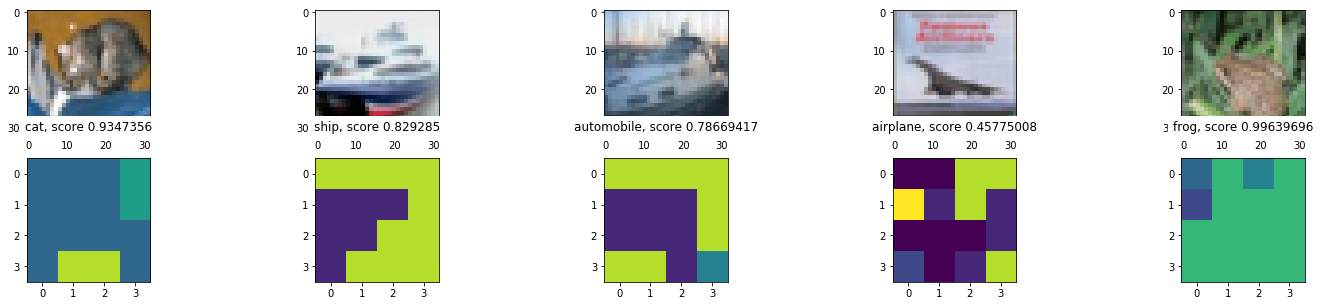

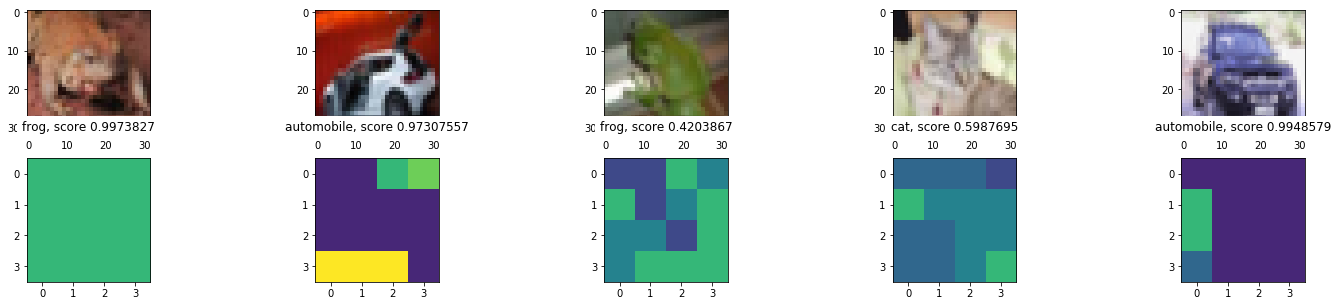

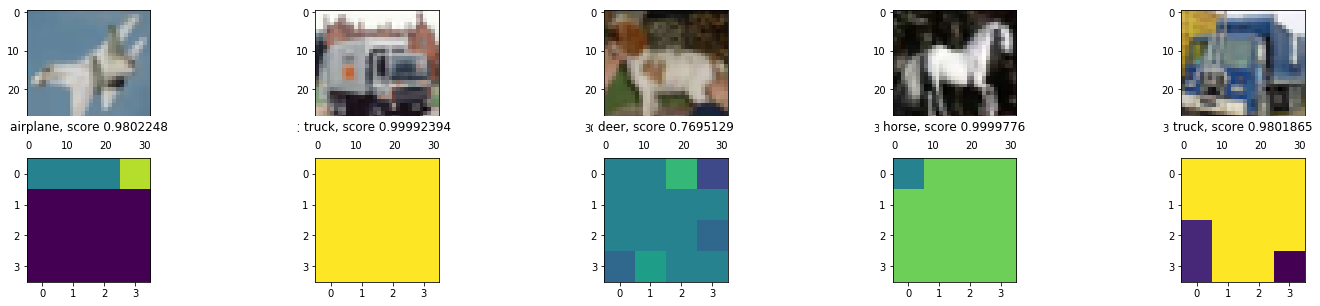

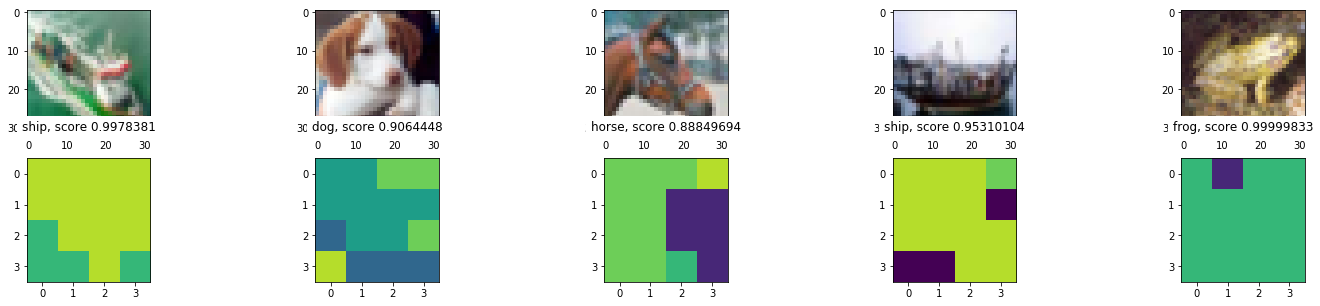

In [24]:
showMaps(range(20), (modelF,modelM), x_test)

### PLEASE RUN THIS COMMAND IF YOU FINISHED THE NOTEBOOK

In [ ]:
import os
temp=os.getpid()
!kill -9 $temp